# **Imports and Constants**

In [1]:
#imports
from __future__ import print_function
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from mpl_toolkits.mplot3d import Axes3D
from pyspark.sql.functions import col
from functools import reduce
from pyspark import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, size, isnan, array_contains, array_min, when, count, pandas_udf, PandasUDFType
from pyspark.sql.types import *
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import pandas as pd 
import glob
import re
import pathlib
import json
import datetime
import numpy as np
import time
import os
import random
import statistics

#env variables
%env PYSPARK_DRIVER_PYTHON=python3.6 
%env PYSPARK_PYTHON=python3.6 

#incompatibility with Pyarrow
#need to install Pyarrow 0.14.1 or lower or Set the environment variable ARROW_PRE_0_15_IPC_FORMAT=1
%env ARROW_PRE_0_15_IPC_FORMAT=1 

#used versions: 
#spark='2.4.3' python='3.6' pyarrow='0.14.1' 

env: PYSPARK_DRIVER_PYTHON=python3.6
env: PYSPARK_PYTHON=python3.6
env: ARROW_PRE_0_15_IPC_FORMAT=1


In [2]:
#paths
DATASET_PATH='/Users/Soroush/Desktop/Thesis/Code/dataset/'

#from google.colab import drive
#drive.mount('/gdrive')

# **Load/Save Dataset**

In [3]:
#load and save .read_pickle() and .to_pickle() 

#save
#dataset.to_pickle(DATASET_PATH+"dataset.pkl")
#aggregated_dataset.to_pickle(DATASET_PATH+"aggregated_dataset.pkl")
#json_dataset.to_pickle(DATASET_PATH+"json_dataset.pkl")
#dataset.to_csv(DATASET_PATH+"dataset.csv")
#aggregated_dataset.to_csv(DATASET_PATH+"aggregated_dataset.csv")
#json_dataset.to_csv(DATASET_PATH+"json_dataset.csv")
#aggregated_dataset_rowBased.to_csv(DATASET_PATH+"aggregated_dataset_rowBased.csv")


#load
dataset=pd.read_pickle(DATASET_PATH+"dataset.pkl")
aggregated_dataset=pd.read_pickle(DATASET_PATH+"aggregated_dataset.pkl")
json_dataset=pd.read_pickle(DATASET_PATH+"json_dataset.pkl")

# **Malicious Samples**

In [4]:
# Generate malicious samples
def h1(x):
    MAX=0.8
    MIN=0.1
    alpha=random.uniform(MIN,MAX)
    temp=np.array(x)
    return (temp*alpha).tolist()

def h2(x):
    MIN_OFF=4 # hour
    DURATION=random.randint(MIN_OFF,23)
    START=random.randint(0,23-DURATION) if DURATION!=23 else 0
    END=START+DURATION
    temp=[]
    for i in range(len(x)):
        if i<START or i>=END:
            temp.append(x[i])
        else:
            temp.append(0.0)
    return temp
    #temp=np.array(x)
    #temp[START:END]=np.array(np.zeros(DURATION))
    #return temp.tolist()
    
def h3(x):
    MAX=0.8
    MIN=0.1
    temp=[]
    for i in range(len(x)):
        temp.append(x[i]*random.uniform(MIN,MAX))
    return temp

def h4(x):
    MAX=0.8
    MIN=0.1
    mean=np.mean(x)
    temp=[]
    for i in range(len(x)):
        temp.append(mean*random.uniform(MIN,MAX))
    return temp

def h5(x):
    MAX=0.8
    MIN=0.1
    mean=np.mean(x)
    temp=[]
    for i in range(len(x)):
        temp.append(mean)
    return temp

def h6(x):
    temp=np.array(x)
    #temp=temp[::-1] 
    temp=np.flipud(temp) 
    return temp.tolist()

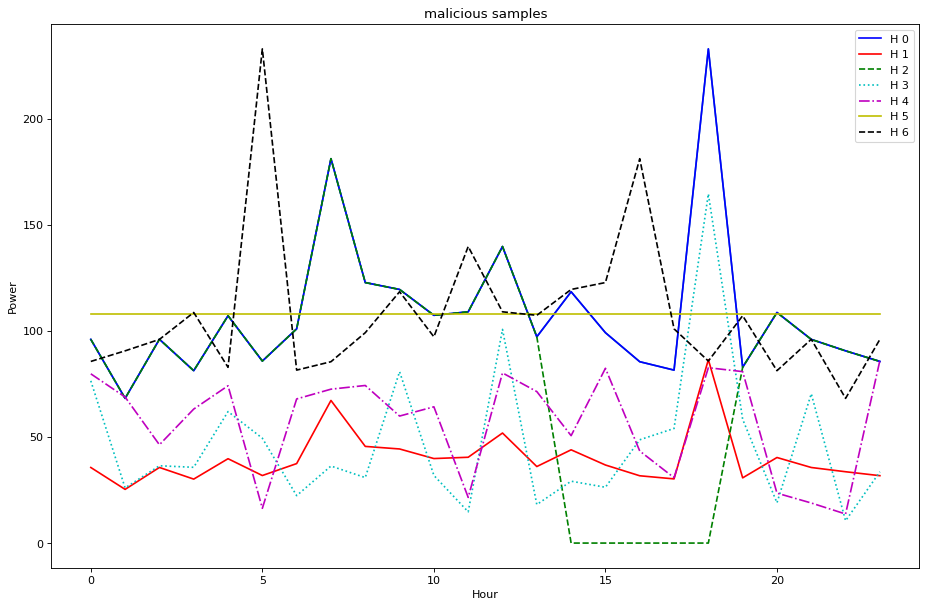

In [18]:
#plot
read_value=[96.00396728515625, 68.20671844482422, 96.05184936523438, 81.24053192138672, 107.14600372314453, 85.7899169921875, 100.9619140625, 181.16192626953125, 122.7833023071289, 119.53163146972656, 107.34815216064453, 108.99268341064453, 139.76922607421875, 97.21031951904297, 118.4515151977539, 99.15070343017578, 85.47505187988281, 81.51718139648438, 232.91493225097656, 82.83419799804688, 108.6827163696289, 95.99102020263672, 90.59868621826172, 85.60449981689453]
lists=[]
colors=['b','r-','g--','c:','m-.','y-','k--']
lists.append(read_value)
lists.append(h1(read_value))
lists.append(h2(read_value))
lists.append(h3(read_value))
lists.append(h4(read_value))
lists.append(h5(read_value))
lists.append(h6(read_value))
plt.figure(num=None, figsize=(14, 9), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel("Hour")
plt.ylabel("Power")
plt.title("malicious samples")
plt.plot(read_value)
for i in range(len(lists)):
    plt.plot(lists[i],colors[i],label = 'H %s'%i)
plt.legend()
plt.show()

# **Prepare Spark Dataset**

In [17]:
#create SparkSession
spark = SparkSession.builder.appName("anomaly_detection").master("local[2]").getOrCreate()
#network problem? type it in commandline: sudo hostname -s 127.0.0.1

#define schema
schema = StructType([
    StructField("#", IntegerType()),
    StructField("date", TimestampType()),
    StructField("id", StringType()),
    StructField("power", StringType())])

#read data
sdf = spark.read.format('csv').options(header='true',inferSchema=True ,schema=schema).load(DATASET_PATH+"aggregated_dataset_rowBased.csv")

#rename columns
def rename_dataframe(sdf):
    names = ['#','date','id','power']
    for c,n in zip(sdf.columns,names):
        sdf=sdf.withColumnRenamed(c,n)
    return sdf
    
sdf=rename_dataframe(sdf)
#sdf.show()
    
#convert power to array
def string_power_to_array(sdf):
    temp=sdf.withColumn("power", f.regexp_replace(f.regexp_replace(f.col("power"), "\\[", ""),"\\]","")
                        .alias("power"))
    temp=temp.withColumn("power",split(col("power"), ",\s*")
                        .cast(ArrayType(FloatType())).alias("power"))
    return temp

sdf=string_power_to_array(sdf)
#sdf.show()

#add "v"alidation column
def add_validation_column(sdf):
    v=True
    temp=sdf.withColumn("V",f.when((size(sdf.power)==24) #array size
                                   & ~(f.array_contains(sdf.power, float('nan'))) #containing NaN
                                   & ~(f.array_max(sdf.power)<=0) #all 0
                                   , True).otherwise(False))
    return temp

sdf=add_validation_column(sdf)
#sdf.show()

#add "N"ormal consumption ("N"onmalicious) column
def add_Normal_column(sdf):
    N=True
    temp=sdf.withColumn("N", f.lit(N))
    return temp

sdf=add_Normal_column(sdf)
#sdf.show()

#filter data
def filter_dataset(sdf,from_date="2014-08-28",to_date="2014-11-29",ID="Apt99"):
    sdf=(sdf.filter(sdf.date > from_date) #filter date (from X)
    .filter(sdf.date <to_date ) #filter date (to Y)
    .filter(sdf.V == True ) #filter validation
    .filter(sdf.id == ID)) #filter IDs
    return sdf

sdf=filter_dataset(sdf)

#add malicious samples
#def add_malicious_samples(sdf):
#    return sdf

#sdf=add_malicious_samples(sdf)
#print(a.head())

def split_power(sdf):
    temp=sdf.select("#","date","id",
           sdf.power[0].alias("H0"), sdf.power[1].alias("H1"), sdf.power[2].alias("H2"),sdf.power[3].alias("H3"),
           sdf.power[4].alias("H4"), sdf.power[5].alias("H5"), sdf.power[6].alias("H6"),sdf.power[7].alias("H7"),
           sdf.power[8].alias("H8"), sdf.power[9].alias("H9"), sdf.power[10].alias("H10"),sdf.power[11].alias("H11"),
           sdf.power[12].alias("H12"), sdf.power[13].alias("H13"), sdf.power[14].alias("H14"),sdf.power[15].alias("H15"),
           sdf.power[16].alias("H16"), sdf.power[17].alias("H17"), sdf.power[18].alias("H18"),sdf.power[19].alias("H19"),
           sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"),sdf.power[23].alias("H23"))
    return temp
    
#split_sdf=split_power(sdf)
#sdf.show()


#sdf.show()
#sdf.printSchema()
#split_sdf=add_validation_column(split_sdf)


In [16]:
#add malicious samples
sdf.show()
#print(sdf.collect())

@pandas_udf(ArrayType(FloatType()))
def random_attack_assigner(x):
    NUMBER_OF_MALICIOUS_GENERATOR=6
    rand = random.randint(1,NUMBER_OF_MALICIOUS_GENERATOR)
    if rand==1:
        return pd.Series(h1(x))
    elif rand==2:
        return pd.Series(h1(x))
    elif rand==3:
        return pd.Series(h3(x))
    elif rand==4:
        return pd.Series(h4(x))
    elif rand==5:
        return pd.Series(h5(x))
    elif rand==6:
        return pd.Series(h6(x))


N=False
sdf_malicious=sdf.withColumn("N", f.lit(N))
sdf_malicious=sdf_malicious.withColumn("power",random_attack_assigner(col("power")))
sdf_malicious.show()
#sdf_malicious.collect()

+-----+-------------------+-----+--------------------+----+----+
|    #|               date|   id|               power|   V|   N|
+-----+-------------------+-----+--------------------+----+----+
|66695|2014-08-28 00:00:00|Apt99|[1.8328255, 7.259...|true|true|
|66696|2014-08-29 00:00:00|Apt99|[0.26582667, 0.28...|true|true|
|66697|2014-08-30 00:00:00|Apt99|[0.26393557, 0.26...|true|true|
|66698|2014-08-31 00:00:00|Apt99|[1.9979289, 2.141...|true|true|
|66699|2014-09-01 00:00:00|Apt99|[2.5140412, 4.676...|true|true|
|66700|2014-09-02 00:00:00|Apt99|[2.42673, 2.26555...|true|true|
|66701|2014-09-03 00:00:00|Apt99|[2.5416589, 5.912...|true|true|
|66702|2014-09-04 00:00:00|Apt99|[0.5217933, 1.846...|true|true|
|66703|2014-09-05 00:00:00|Apt99|[1.4139111, 5.459...|true|true|
|66704|2014-09-06 00:00:00|Apt99|[4.768431, 4.9625...|true|true|
|66705|2014-09-07 00:00:00|Apt99|[5.2130256, 4.962...|true|true|
|66706|2014-09-08 00:00:00|Apt99|[3.7041945, 15.23...|true|true|
|66707|2014-09-09 00:00:0

In [207]:
def prepare_for_kmeans(sdf): 
    
    temp=sdf
    
    #define function for validation
    def add_validation_column(sdf):
        v=True
        temp=sdf.withColumn("V",f.when((size(sdf.power)==24) #array size
                                   & ~(f.array_contains(sdf.power, float('nan'))) #containing NaN
                                   & ~(f.array_max(sdf.power)<=0) #all 0
                                   , True).otherwise(False))
        return temp

    #call the split_power function
    temp=add_validation_column(temp)
    
    #define function for split power column
    def split_power(sdf):
        temp=sdf.select("#","V","date","id",
           sdf.power[0].alias("H0"), sdf.power[1].alias("H1"), sdf.power[2].alias("H2"),sdf.power[3].alias("H3"),
           sdf.power[4].alias("H4"), sdf.power[5].alias("H5"), sdf.power[6].alias("H6"),sdf.power[7].alias("H7"),
           sdf.power[8].alias("H8"), sdf.power[9].alias("H9"), sdf.power[10].alias("H10"),sdf.power[11].alias("H11"),
           sdf.power[12].alias("H12"), sdf.power[13].alias("H13"), sdf.power[14].alias("H14"),sdf.power[15].alias("H15"),
           sdf.power[16].alias("H16"), sdf.power[17].alias("H17"), sdf.power[18].alias("H18"),sdf.power[19].alias("H19"),
           sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"),sdf.power[23].alias("H23"))
        return temp
    
    #call the split_power function
    temp=split_power(temp)
    
    #filter date
    #temp=temp.filter(temp.date > "2014-08-15").filter(temp.date < "2014-08-19") # filter dates
    temp=temp.filter(temp.id == "Apt40") # filter IDs
    
    #filter valid rows
    temp=temp.filter(temp.V==True)
    
    FEATURES = ['H0', 'H1', 'H2','H3', 'H4', 'H5','H6', 'H7', 'H8','H9', 'H10', 'H11',
            'H12', 'H13', 'H14','H15', 'H16', 'H17','H18', 'H19', 'H20','H21', 'H22', 'H23']
    
    #make ready
    vecAssembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    df_kmeans = vecAssembler.transform(temp).select('id', 'features')
    return df_kmeans


In [ ]:
#run k-means

# Loads data
sdf_kmeans=prepare_for_kmeans(sdf)

#show data
sdf_kmeans.show()
print(sdf_kmeans.count())
sdf_kmeans.printSchema()

#find best k
MAX_k=10
costs = np.zeros(MAX_k)
silhouettes = np.zeros(MAX_k)
for k in range(2,MAX_k):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(sdf_kmeans)
    costs[k] = model.computeCost(sdf_kmeans) # requires Spark 2.0 or later
    predictions = model.transform(sdf_kmeans)
    evaluator = ClusteringEvaluator()
    silhouettes[k] = evaluator.evaluate(predictions)
    
#show best k
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,MAX_k),silhouettes[2:MAX_k])
ax.set_xlabel('k')
ax.set_ylabel('silhouette')

#show best k
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,MAX_k),costs[2:MAX_k])
ax.set_xlabel('k')
ax.set_ylabel('cost')

# Trains a k-means model.
kmeans = KMeans().setK(6).setSeed(1)
model = kmeans.fit(sdf_kmeans)

# Make predictions
predictions = model.transform(sdf_kmeans)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

transformed = model.transform(sdf_kmeans).select('id', 'prediction')
rows = transformed.collect() 
print(rows[:3])
#prediction = spark.createDataFrame(rows)
#prediction.show()

# **MAIN**

In [ ]:
    NUMBER_OF_MALICIOUS_GENERATOR=6
    rand = random.randint(1,NUMBER_OF_MALICIOUS_GENERATOR)
    if rand==1:
        return h1(x)
    elif rand==2:
        return h2(x)
    elif rand==3:
        return h3(x)
    elif rand==4:
        return h4(x)
    elif rand==5:
        return h5(x)
    elif rand==6:
        return h6(x)

# **TEST**

In [12]:
a=prepare_for_kmeans(sdf)
a.describe().show()

+-------+-----+
|summary|   id|
+-------+-----+
|  count|  778|
|   mean| null|
| stddev| null|
|    min|Apt40|
|    max|Apt40|
+-------+-----+



# **Other**

In [ ]:
#create json data from stored dataframe

def to_json(final):
    PERIOD=60

    data_for_json=final.loc[:, final.columns != 'date']

    def date_to_str(o):
        if isinstance(o, datetime.datetime):
            return o.__str__()

    json_dataframe = pd.DataFrame(columns=['data']) #creates a new dataframe that's empty
    L  = []

    import json
    import datetime
    import time

    r, c = data_for_json.shape
    for i in range(0, r):
        for j in range(0, c):
            data = {}
            data['id'] = data_for_json.columns.values[j]
            data['power'] = data_for_json.iloc[i][j]
            data['date']=data_for_json.index.tolist()[i]
            json_data = json.dumps(data,default=date_to_str)
            L.append(json_data)
            #json_dataframe=json_dataframe.append(json_data,ignore_index=True)

    json_dataframe = pd.DataFrame(L, columns=['data'])
    return json_dataframe

In [ ]:
#load by schema

schema = StructType([
  StructField("num", IntegerType()),
    StructField("date", TimestampType()),
    StructField("id", StringType()),
  StructField("power", ArrayType(
      StructType([
          StructField("H0", FloatType(), True),
          StructField("H1", FloatType(), True),
          StructField("H2", FloatType(), True),
          StructField("H3", FloatType(), True),
          StructField("H4", FloatType(), True),
          StructField("H5", FloatType(), True),
          StructField("H6", FloatType(), True),
          StructField("H7", FloatType(), True),
          StructField("H8", FloatType(), True),
          StructField("H9", FloatType(), True),
          StructField("H10", FloatType(), True),
          StructField("H11", FloatType(), True),
          StructField("H12", FloatType(), True),
          StructField("H13", FloatType(), True),
          StructField("H14", FloatType(), True),
          StructField("H15", FloatType(), True),
          StructField("H16", FloatType(), True),
          StructField("H17", FloatType(), True),
          StructField("H18", FloatType(), True),
          StructField("H19", FloatType(), True),
          StructField("H20", FloatType(), True),
          StructField("H21", FloatType(), True),
          StructField("H22", FloatType(), True),
          StructField("H23", FloatType(), True)
      ])
   )
             )])

a = spark.read.format('csv').schema(schema).option("header", "true").load(DATASET_PATH+"f.csv")
a.show()

In [ ]:
#test pandas_udf

from pyspark.sql.functions import pandas_udf, PandasUDFType

my_schema = StructType([
    StructField("id", IntegerType()),
    StructField("age", IntegerType())])
df=spark.read.csv("test.csv", header=True,schema=my_schema)
df.show()
df.printSchema()

def plus_one(a):
    return a+1

plus_one_udf = pandas_udf(plus_one, returnType=IntegerType())

df.select(plus_one_udf(col("age"))).show()